In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping


df=pd.read_csv("EV_INDIA_SALES.csv")
df=df.drop(['category','parameter','mode','unit'], axis=1)
df.head(25)
# Create separate datasets for PHEV and BEV

df = df[df['powertrain'] == 'BEV']
df=df.drop(['region','powertrain'],axis=1)
df
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['value']])

# Prepare the data for LSTM
lookback = 3  # Number of previous time steps to consider
X, y = [], []
for i in range(len(df) - lookback):
    X.append(scaled_data[i:i+lookback])
    y.append(scaled_data[i+lookback])
X, y = np.array(X), np.array(y)

# Build the LSTM model with regularization and dropout
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lookback, 1), kernel_regularizer=l2(0.001)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X, y, epochs=200, batch_size=1, verbose=2, callbacks=[early_stopping])

# Make predictions on the entire time series
y_pred = model.predict(X)
# Inverse scale the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_actual_inv = scaler.inverse_transform(y)

Epoch 1/200
10/10 - 2s - loss: 0.1046 - 2s/epoch - 193ms/step
Epoch 2/200
10/10 - 0s - loss: 0.1022 - 34ms/epoch - 3ms/step
Epoch 3/200
10/10 - 0s - loss: 0.0979 - 33ms/epoch - 3ms/step
Epoch 4/200
10/10 - 0s - loss: 0.0966 - 32ms/epoch - 3ms/step
Epoch 5/200
10/10 - 0s - loss: 0.0935 - 30ms/epoch - 3ms/step
Epoch 6/200
10/10 - 0s - loss: 0.0917 - 31ms/epoch - 3ms/step
Epoch 7/200
10/10 - 0s - loss: 0.0917 - 30ms/epoch - 3ms/step
Epoch 8/200
10/10 - 0s - loss: 0.0889 - 30ms/epoch - 3ms/step
Epoch 9/200
10/10 - 0s - loss: 0.0888 - 31ms/epoch - 3ms/step
Epoch 10/200
10/10 - 0s - loss: 0.0875 - 33ms/epoch - 3ms/step
Epoch 11/200
10/10 - 0s - loss: 0.0866 - 37ms/epoch - 4ms/step
Epoch 12/200
10/10 - 0s - loss: 0.0860 - 34ms/epoch - 3ms/step
Epoch 13/200
10/10 - 0s - loss: 0.0856 - 32ms/epoch - 3ms/step
Epoch 14/200
10/10 - 0s - loss: 0.0855 - 32ms/epoch - 3ms/step
Epoch 15/200
10/10 - 0s - loss: 0.0846 - 32ms/epoch - 3ms/step
Epoch 16/200
10/10 - 0s - loss: 0.0843 - 33ms/epoch - 3ms/step
E

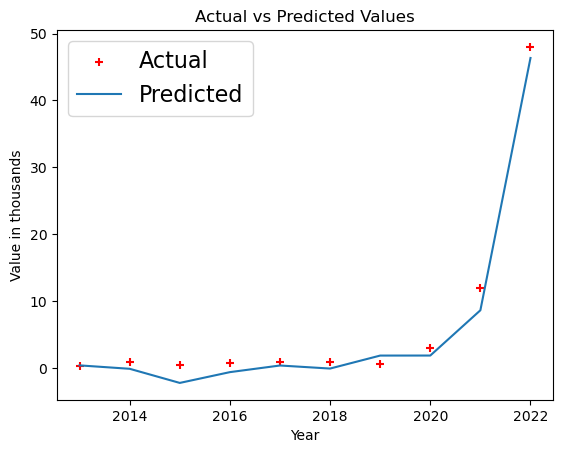

RMSE: 1659.0300775184235


In [8]:
# Plot the actual and predicted values
plt.scatter(df['year'][lookback:], y_actual_inv/1000,color='red',marker='+', label='Actual')
plt.plot(df['year'][lookback:], y_pred_inv/1000, label='Predicted')
plt.xlabel('Year')
plt.ylabel('Value in thousands')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_actual_inv, y_pred_inv))
print('RMSE:', rmse)

In [9]:
# Predict values for the future years
future_years = [2023,2024,2025,2026,2027]
X_future = scaled_data[-lookback:].reshape(1, lookback, 1)
predicted_values = []
for year in future_years:
    y_pred = model.predict(X_future)[0][0]
    predicted_values.append(y_pred)
    X_future = np.roll(X_future, -1)
    X_future[-1][-1] = y_pred

# Inverse scale the predicted values
predicted_values_inv = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

# Create a DataFrame with the predicted values
df_predicted = pd.DataFrame({'year': future_years, 'predicted_value': predicted_values_inv.flatten()}).astype(int)
print(df_predicted)

1/1 [==============================] - 0s 38ms/step
   year  predicted_value
0  2023           112886
1  2024           261443
2  2025           806518
3  2026          2552803
4  2027          8486425


   year  predicted_value
0  2023           112886
1  2024           261443
2  2025           806518
3  2026          2552803
4  2027          8486425

In [14]:
predicted_values

array([ 112886,  261443,  806518, 2552803, 8486425])

In [45]:
predicted_value=([48000, 112886,  261443,  806518, 2552803, 8486425])
predicted_values= np.array(predicted_value)
future_year = ([2022,2023,2024,2025,2026,2027])
future= np.array(future_year)

In [40]:
future_years

array([2022, 2023, 2024, 2025, 2026, 2027])

   year  predicted_value
0  2023           112886
1  2024           261443
2  2025           806518
3  2026          2552803
4  2027          8486425

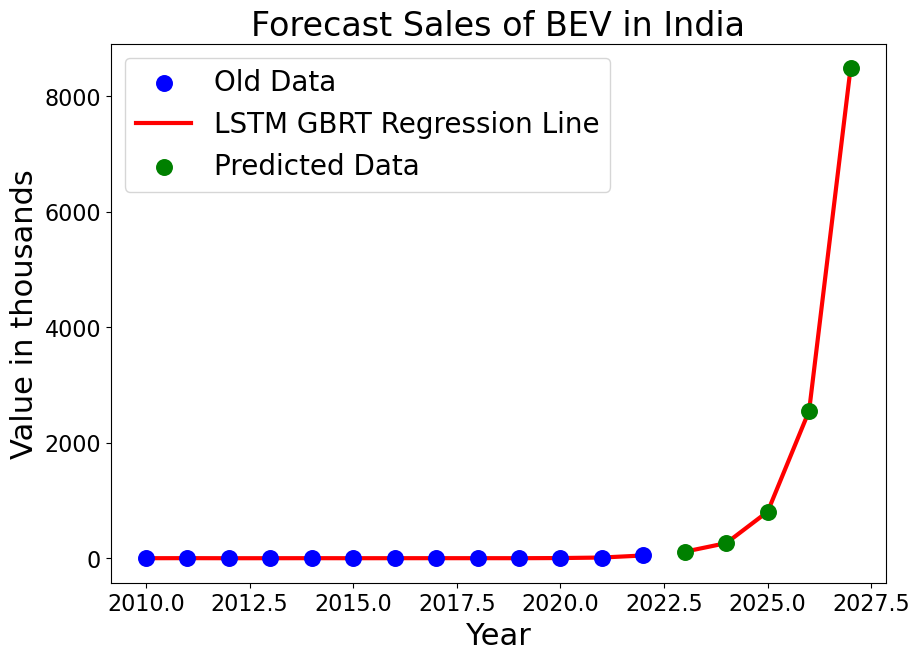

In [49]:
import matplotlib.pyplot as plt

# Prepare the data for plotting
actual_values = df['value'].values
years = df['year'].values
future_years = df_predicted['year'].values
predicted_values = df_predicted['predicted_value'].values
plt.figure(figsize=(10,7))
# Plot actual values
plt.scatter(years, actual_values/1000,color='blue',marker='o', s=125, label='Old Data',zorder=10)
plt.plot(future_years, predicted_values/1000, color='red', label='LSTM GBRT Regression Line', linewidth=3)        
plt.plot(years, actual_values/1000,color='red', linewidth=3)
plt.scatter(future_years, predicted_values/1000, color='green', marker='o', s=125,label='Predicted Data',zorder=10)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Value in thousands', fontsize=22)
plt.title('Forecast Sales of BEV in India', fontsize=24)
plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [57]:
predicted_value=([48000, 112886,  261443,  806518, 2552803, 8486425])
predicted_values= np.array(predicted_value)
future_year = ([2022,2023,2024,2025,2026,2027])
future_years= np.array(future_year)

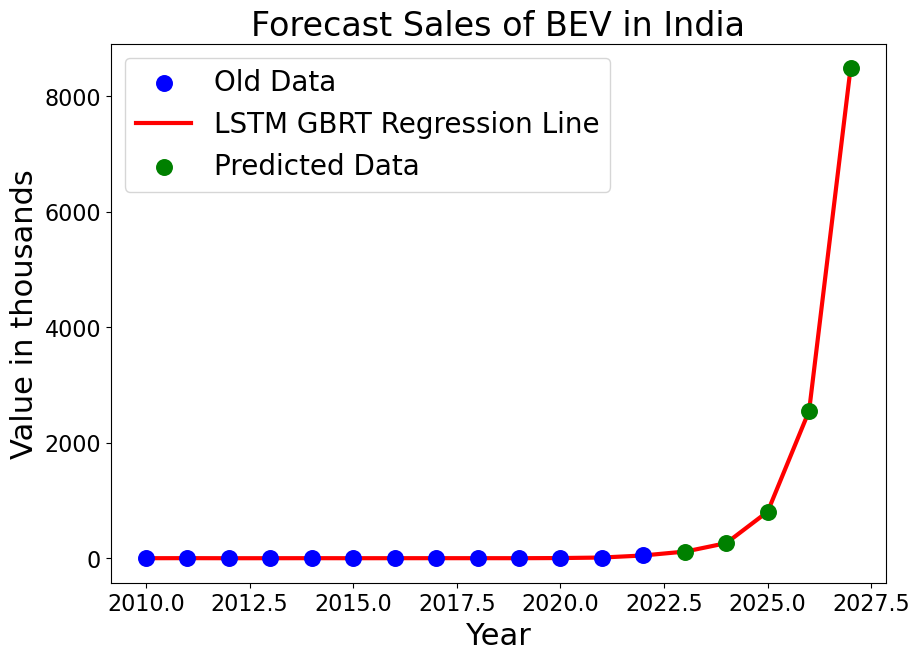

In [62]:
import matplotlib.pyplot as plt

# Prepare the data for plotting
actual_values = df['value'].values
years = df['year'].values
future_years = df_predicted['year'].values
predicted_values = df_predicted['predicted_value'].values
plt.figure(figsize=(10,7))
# Plot actual values
plt.scatter(years, actual_values/1000,color='blue',marker='o', s=125, label='Old Data',zorder=10)
plt.plot(future_years, predicted_values/1000, color='red', label='LSTM GBRT Regression Line', linewidth=3)        
plt.plot(years, actual_values/1000,color='red', linewidth=3)
plt.scatter(future_years, predicted_values/1000, color='green', marker='o', s=125,label='Predicted Data',zorder=10)
plt.plot(([2022,2023]),([48,115]),color='red', linewidth=3)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Value in thousands', fontsize=22)
plt.title('Forecast Sales of BEV in India', fontsize=24)
plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [52]:
future_years

array([2023, 2024, 2025, 2026, 2027])

In [56]:
predicted_values

array([ 112886,  261443,  806518, 2552803, 8486425])